# TensorFlow를 사용한 Convolution neural network

"딥러닝"은 일반적으로 인간의 두뇌가 학습하고 결정을 내리는 방식을 합성하는 여러 계층이있는 신경망을 사용하는 일반적인 용어입니다. *convolution neural network*(합성곱 신경망, CNN)은 가중치를 적용하고 가장자리, 모서리 등과 같은 패턴을 식별하기 위해 행렬 값에 대해 여러 필터를 거치고 계산하여 숫자 값의 행렬에서 *feature*(특징)을 추출하는 일종의 신경망입니다. 그런 다음 이러한 패턴의 숫자 표현이 완전히 연결된 신경망 계층으로 전달되어 기능을 특정 클래스에 매핑합니다.

CNN을 만드는 데 일반적으로 사용되는 여러 프레임 워크가 있습니다. 이 노트북에서는 TensorFlow를 사용하여 간단한 예제 CNN을 빌드합니다.

## 라이브러리 설치 및 가져 오기

먼저 필요한 TensorFlow 라이브러리를 설치하고 가져 오겠습니다.

In [1]:
#!pip install --upgrade tensorflow

In [2]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.5.0
Keras version: 2.5.0


## 데이터 탐색

이번 실습에서는 기하학적 모양의 이미지를 분류하는 CNN기반 분류 모델을 학습 하려고 합니다. 모델이 식별해야하는 기하학 모양의 클래스들을 살펴 보겠습니다.

3 classes:
['circle', 'square', 'triangle']


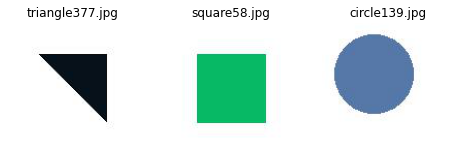

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

# The images are in the data/shapes folder
data_folder = 'data/shapes'

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

## 데이터 준비

모델을 훈련시키기 전에 데이터를 준비해야합니다. 먼저 전처리를 진행 해줍니다. 특성 값을 255로 나누어 0과 1 사이의 부동 소수점 값으로 정규화하고 데이터를 분할하여 70%를 모델 학습에 사용하고 30%를 테스트 데이터로 모델 유효성을 검사하게 됩니다. 데이터를 로드 할 때 데이터 생성기는 "hot-encoded" 숫자 레이블을 할당하여 데이터가 저장된 하위 폴더에 따라 각 이미지가 속한 클래스를 나타냅니다. 이 경우 세 개의 하위 폴더 (*circle*, *square* 및 *triangle*)가 있으므로 레이블은 이러한 클래스 중 이미지와 연결된 클래스를 나타내는 3 개의 *0* 또는 *1* 값으로 구성됩니다. 예를 들어 레이블 [0 1 0]은 이미지가 두 번째 클래스 (*정사각형*)에 속함을 나타냅니다.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 840 images belonging to 3 classes.
Preparing validation dataset...
Found 360 images belonging to 3 classes.
Data generators ready


## CNN 정의

이제 모델을 만들 준비가 되었습니다. 여기에는 CNN에 대한 계층을 정의하고 다중 클래스 분류를 위해 컴파일(comfile)하는 것까지 포함됩니다.

In [5]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 123, 32)      3488      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        36896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        36896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0

## 모델 학습

CNN의 레이어가 정의되었으므로 이미지 데이터를 사용하여 모델을 훈련 할 준비가되었습니다. 아래에서는 5회 반복(*epochs*)을 사용하여 30개 이미지 배치로 모델을 훈련시키고 검증을 위해 데이터의 30%를 보류 합니다. 각 Epoch 후에 손실 함수는 모델의 오류(손실, *Loss*)를 측정하고 가중치(첫 번째 반복에서 무작위로 생성됨)를 조정하여 정확도를 개선해나갑니다.

> **참고**: 이 간단한 예제에서는 훈련 시간을 최소화하기 위해 5개의 Epoch만 사용합니다. 실제 CNN은 일반적으로 이보다 더 많은 시대에 걸쳐 훈련됩니다. CNN 모델 학습은 많은 행렬 및 벡터 기반 작업에 프로세서를 많이 사용하기 때문에, 이러한 종류의 계산에 최적화된 GPU를 활용할 수있는 시스템에서이 작업을 수행하는 것이 좋습니다. CPU 기반 시스템에서 완료하는 데 시간이 걸립니다. 교육이 진행됨에 따라 상태가 표시됩니다.

In [6]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
28/28 [==============================] - 21s 57ms/step - loss: 0.8139 - accuracy: 0.5905 - val_loss: 0.3825 - val_accuracy: 0.9417
Epoch 2/5
28/28 [==============================] - 1s 41ms/step - loss: 0.2834 - accuracy: 0.8750 - val_loss: 0.1148 - val_accuracy: 0.9611
Epoch 3/5
28/28 [==============================] - 1s 39ms/step - loss: 0.0910 - accuracy: 0.9643 - val_loss: 0.0184 - val_accuracy: 0.9972
Epoch 4/5
28/28 [==============================] - 1s 41ms/step - loss: 0.0175 - accuracy: 0.9952 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 5/5
28/28 [==============================] - 1s 42ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000


## Loss(손실) 확인하기

각 epoch에 대한 평균 훈련 및 검증 손실을 추적합니다. 그 이유는 모델이 학습됨에 따라 손실이 감소했는지 확인하고 *과적합* (검증 데이터의 손실이 평준화 되거나 증가하기 시작한 후에도 학습 데이터의 손실이 계속적으로 감소함을 나타냄)을 감지하기 위해 이를 시각화 하여 살펴봅니다.

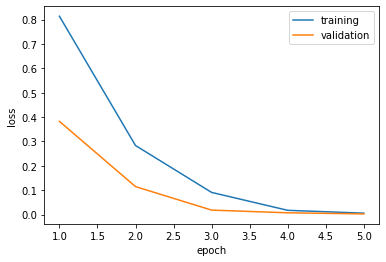

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 모델 성능 평가

테스트 데이터를 기반으로 최종 정확도를 볼 수 있지만 일반적으로 성능 메트릭을 좀 더 자세히 살펴 보는게 좋습니다. 모델이 각 클래스를 얼마나 잘 예측하는지 확인하기 위해 confusion matrix(혼동 행렬)을 시각화 해 보겠습니다.

Generating predictions from validation data...


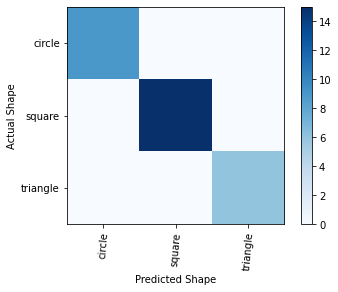

In [8]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## 훈련 된 모델 저장

모델을 나중에 사용할 수 있도록 학습된 가중치를 저장할 수 있습니다.

In [9]:
# Save the trained model
modelFileName = 'models/shape_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as models/shape_classifier.h5


## 훈련된 모델 사용

이제 모델을 저장 했으므로, 새로운 이미지의 클래스를 예측하는데 사용할 수 있습니다.

triangle


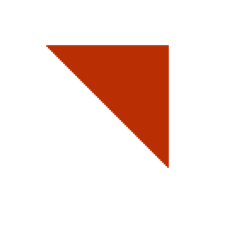

In [10]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return np.array(img)

# Create a random test image
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# Use the classifier to predict the class
model = models.load_model(modelFileName) # loads the saved model
class_idx = predict_image(model, img)
print (classnames[class_idx])

## 더 읽을 거리

TensorFlow를 사용한 CNN에 대한 자세한 내용은 [TensorFlow 문서](https://www.tensorflow.org/overview)를 참고 하세요.

## 과제 : Safari 이미지 분류

이 노트북 실습이 CNN 교육 및 평가의 주요 단계를 보여 주었기를 바라며, [/ challenges / 05-Safari CNN Challenge.ipynb](./challenges/05%20-%20Safari%20CNN%20Challenge.ipynb) 노트북에서 Safari 이미지 분류 챌린지를 통해 배운 내용을 실행하는 것도 좋아보입니다.

> **참고**: 이 옵션 챌린지를 완료하는 데 걸리는 시간은이 연습의 예상 시간에 포함되지 않습니다. 원하는만큼 시간을 적게 또는 많이 사용할 수 있습니다!
